In [3]:
%pip install pandas numpy scikit-learn matplotlib tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [3]:
filepath = '../data/eq_catalog.csv'
df = pd.read_csv(filepath)  # Adjust path if needed

# Rename columns if needed
df.rename(columns={
    'N_Lat': 'Latitude',
    'E_Long': 'Longitude'
}, inplace=True)

# Define features and target
features = ['Latitude', 'Longitude', 'Depth']
target = 'Mag'

# Convert columns to numeric
for col in features + [target]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

sequence_length = 10
x_seq = []
y_seq = []

for i in range(len(scaled_data) - sequence_length):
    x_seq.append(scaled_data[i:i+sequence_length, :-1])  # features
    y_seq.append(scaled_data[i+sequence_length, -1])     # target

x_seq = np.array(x_seq)
y_seq = np.array(y_seq)

# Remove sequences with any NaNs
valid_indices = ~np.isnan(x_seq).any(axis=(1, 2)) & ~np.isnan(y_seq)
x_seq = x_seq[valid_indices]
y_seq = y_seq[valid_indices]


In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    x_seq, y_seq, test_size=0.2, random_state=42
)


In [6]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10


e:\miniconda3\envs\thesisconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0165 - val_loss: 0.0123
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0141 - val_loss: 0.0123
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0120
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0122
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - val_loss: 0.0118
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - val_loss: 0.0117
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132 - val_loss: 0.0116
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0117
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0123
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - val_loss: 0.0115


In [7]:
y_pred = model.predict(x_test)

# Inverse transform the target values only
scaler_target = MinMaxScaler()
scaler_target.fit(df[[target]])  # Fit on original magnitude column

y_pred_inv = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [13]:
for i in range(5):
    print(f"Predicted: {y_pred_inv[i]:.2f} | Actual: {y_test_inv[i]:.2f}")


Predicted: 5.71 | Actual: 5.10
Predicted: 5.66 | Actual: 5.70
Predicted: 5.65 | Actual: 6.80
Predicted: 5.66 | Actual: 6.60
Predicted: 5.51 | Actual: 5.10


In [14]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 0.37
RMSE: 0.48


In [ ]:
for i in range(5):
    print(f"Predicted: {y_pred_inv[i]:.2f} | Actual: {y_test_inv[i]:.2f}")


Predicted: 0.40 | Actual: 0.26
Predicted: 0.39 | Actual: 0.40
Predicted: 0.38 | Actual: 0.65
Predicted: 0.39 | Actual: 0.60
Predicted: 0.35 | Actual: 0.26


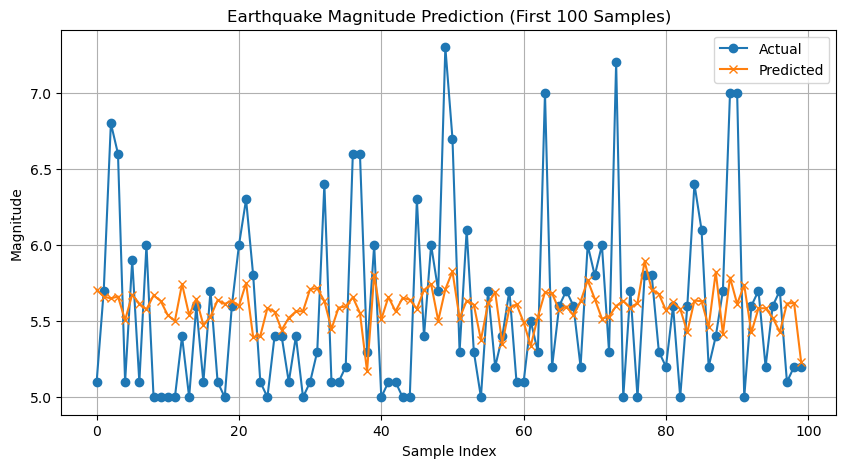

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test_inv[:100], label='Actual', marker='o')
plt.plot(y_pred_inv[:100], label='Predicted', marker='x')
plt.title("Earthquake Magnitude Prediction (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()
